**Generate Real-Time Data**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from sklearn.ensemble import IsolationForest


**Sample Traffic Data**

In [3]:
traffic_data = np.random.randint(100, 500, size=100)
time_points = np.arange(len(traffic_data))  # Create an array of time points

**Initialize IsolationForest model**

In [4]:
isolation_forest = IsolationForest(contamination=0.1)  # 10% contamination to identify top anomalies
data_seen_so_far = []

**Let's attempt to plot and animate traffic**

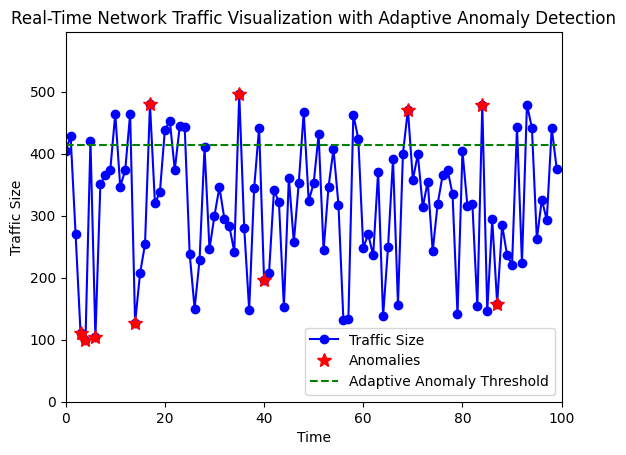

In [5]:
fig, ax = plt.subplots()
line, = ax.plot([], [], marker='o', color='b', label="Traffic Size")
anomaly_points, = ax.plot([], [], 'r*', markersize=10, label="Anomalies")  # Red stars for anomalies
threshold_line, = ax.plot([], [], 'g--', label="Adaptive Anomaly Threshold")  # Green dashed line for threshold

# Set plot limits and labels
ax.set_xlim(0, len(traffic_data))
ax.set_ylim(0, max(traffic_data) + 100)
ax.set_xlabel("Time")
ax.set_ylabel("Traffic Size")
ax.set_title("Real-Time Network Traffic Visualization with Adaptive Anomaly Detection")
ax.legend()

# Initialization function for FuncAnimation
def init():
    line.set_data([], [])
    anomaly_points.set_data([], [])
    threshold_line.set_data([], [])
    return line, anomaly_points, threshold_line

# Animation function to add points one by one with anomaly detection and threshold update
def animate(i):
    # Add new data point to the dataset seen so far
    data_seen_so_far.append([traffic_data[i]])

    # Update the IsolationForest model on the data seen so far
    if len(data_seen_so_far) > 5:  # Start detecting anomalies once we have enough points
        isolation_forest.fit(data_seen_so_far)
        predictions = isolation_forest.predict(data_seen_so_far)  # -1 for anomalies, 1 for normal

        # Separate normal and anomaly points
        normal_points = [point for j, point in enumerate(data_seen_so_far) if predictions[j] == 1]
        anomaly_points_list = [point for j, point in enumerate(data_seen_so_far) if predictions[j] == -1]

        # Calculate the adaptive threshold as the maximum of recent normal points
        if normal_points:
            threshold_value = np.mean([point[0] for point in normal_points]) + np.std([point[0] for point in normal_points])
        else:
            threshold_value = 400  # Default if no normal points are available

        # Prepare x and y data for plotting
        x_data = np.arange(i + 1)
        y_data = np.array(data_seen_so_far).flatten()

        # Update line data
        line.set_data(x_data, y_data)

        # Update anomaly points on the plot
        if anomaly_points_list:
            anomaly_times = [x_data[j] for j, pred in enumerate(predictions) if pred == -1]
            anomaly_values = [y_data[j] for j, pred in enumerate(predictions) if pred == -1]
            anomaly_points.set_data(anomaly_times, anomaly_values)
        else:
            anomaly_points.set_data([], [])

        # Update the adaptive threshold line
        threshold_line.set_data([0, i], [threshold_value, threshold_value])

    return line, anomaly_points, threshold_line

# Create the animation
ani = FuncAnimation(fig, animate, frames=len(traffic_data), init_func=init, blit=True, interval=100)

# Display the animation in the notebook
HTML(ani.to_jshtml())


**What if we choose a specific time frame? Test anomalies in a time frame**

In [6]:
# Get user input for the time range
time_start = int(input("Enter the start time (e.g., 0): "))
time_end = int(input(f"Enter the end time (e.g., up to {len(traffic_data)-1}): "))

Enter the start time (e.g., 0): 2
Enter the end time (e.g., up to 99): 50


Within this time frame, let's filter traffic data and time points. Then let's initialize and fit an Isolation Forest model to it.

In [7]:
filtered_time_points = time_points[time_start:time_end + 1]
filtered_traffic_data = traffic_data[time_start:time_end + 1]

# Initialize and fit the IsolationForest model on the filtered data
isolation_forest = IsolationForest(contamination=0.1)  # Adjust contamination level as needed
filtered_data_reshaped = np.array(filtered_traffic_data).reshape(-1, 1)  # Reshape for model input
isolation_forest.fit(filtered_data_reshaped)


IsolationForest(contamination=0.1)

**Predict anomilies in the filtered data, and figure out the threshold when it changes.**

In [8]:
predictions = isolation_forest.predict(filtered_data_reshaped)
anomalies = [(t, x) for t, x, pred in zip(filtered_time_points, filtered_traffic_data, predictions) if pred == -1]
anomalous_times = [t for t, x in anomalies]
anomalous_values = [x for t, x in anomalies]

# Calculate the adaptive threshold as the mean + standard deviation of normal points within the range
normal_points = [x for x, pred in zip(filtered_traffic_data, predictions) if pred == 1]
adaptive_threshold = np.mean(normal_points) + np.std(normal_points) if normal_points else 400

Let's plot and see!

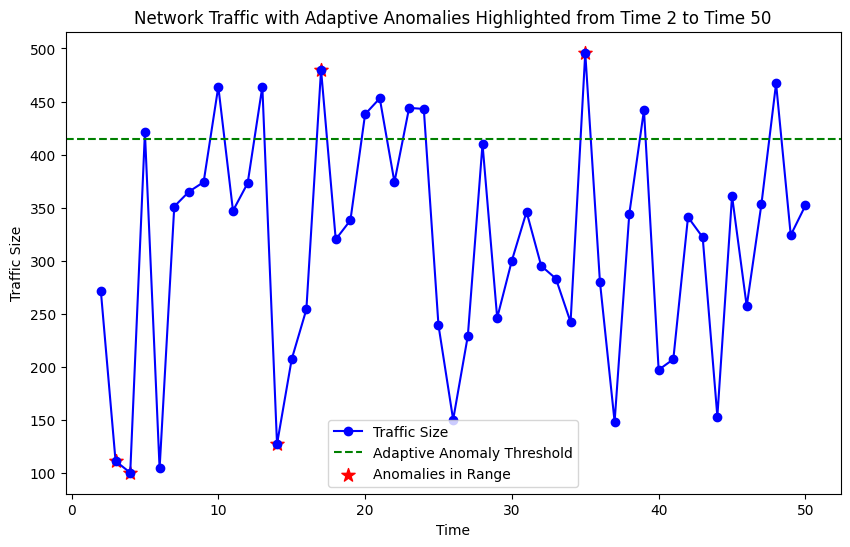

In [9]:
# Plot the filtered traffic data
plt.figure(figsize=(10, 6))
plt.plot(filtered_time_points, filtered_traffic_data, marker='o', color='b', label="Traffic Size")
plt.axhline(y=adaptive_threshold, color='g', linestyle='--', label="Adaptive Anomaly Threshold")

# Plot anomalies within the time range with larger, distinct markers
plt.scatter(anomalous_times, anomalous_values, color='red', s=100, marker='*', label="Anomalies in Range")

# Add labels and title
plt.xlabel("Time")
plt.ylabel("Traffic Size")
plt.title(f"Network Traffic with Adaptive Anomalies Highlighted from Time {time_start} to Time {time_end}")
plt.legend()
plt.show()